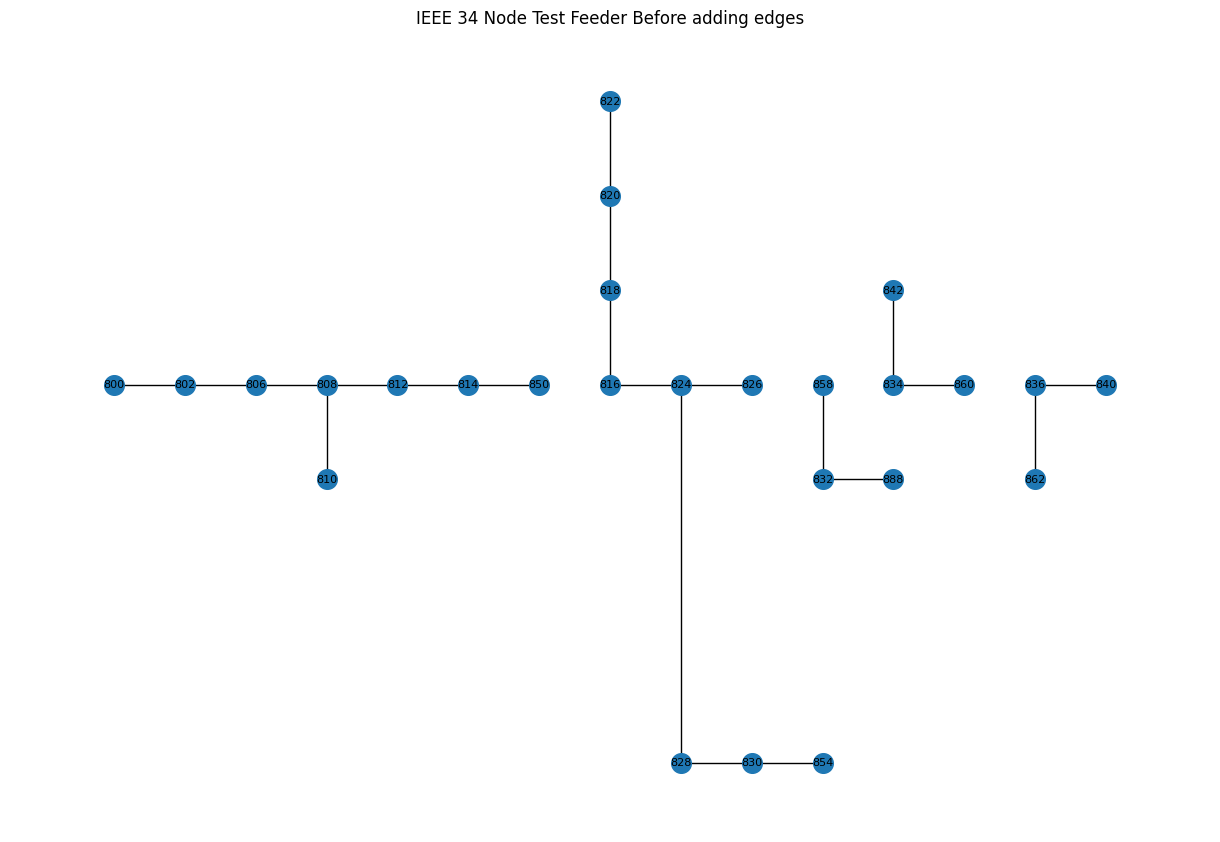

EdgesLenghts:  [(800, 802, {'weight': 2580}), (802, 806, {'weight': 1730}), (806, 808, {'weight': 32230}), (808, 810, {'weight': 5804}), (808, 812, {'weight': 37500}), (812, 814, {'weight': 29730}), (814, 850, {'weight': 10}), (816, 818, {'weight': 1710}), (816, 824, {'weight': 10210}), (818, 820, {'weight': 48150}), (824, 826, {'weight': 3030}), (824, 828, {'weight': 840}), (820, 822, {'weight': 13740}), (828, 830, {'weight': 20440}), (830, 854, {'weight': 520}), (832, 858, {'weight': 4900}), (832, 888, {'weight': 0}), (834, 860, {'weight': 2020}), (834, 842, {'weight': 280}), (836, 840, {'weight': 860}), (836, 862, {'weight': 280})]


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random


# Load feeder34 from excel file
df34 = pd.read_excel("./feeder34/line data.xls")
df123 = pd.read_excel("./feeder123/line data.xls")
G34 = nx.Graph()
G123 = nx.Graph()
for _, row in df34.iterrows():
    from_node = row["Node A"]
    to_node = row["Node B"]
    length = row["Length(ft.)"]
    G34.add_edge(from_node, to_node, weight=length)

# Definir posições fixas (x,y) manualmente
pos = {
    800: (0, 0),
    802: (1, 0),
    806: (2, 0),
    808: (3, 0),
    810: (3, -1),
    812: (4, 0),
    814: (5, 0),
    816: (7, 0),
    818: (7, 1),
    820: (7, 2),
    822: (7, 3),
    824: (8, 0),
    826: (9, 0),
    828: (8, -4),
    830: (9, -4),
    832: (10, -1),
    834: (11, 0),
    836: (13, 0),
    838: (13, -2),
    840: (14, 0),
    842: (11, 1),
    844: (11, 2),
    846: (11, 3),
    848: (11, 4),
    850: (6, 0),
    852: (10, -3),
    854: (10, -4),
    856: (11, -4),
    858: (10, 0),
    860: (12, 0),
    862: (13, -1),
    864: (10, 1),
    888: (11, -1),
    890: (12, -1)
}


# Desenhar G34 
plt.figure(figsize=(12, 8))
nx.draw(G34, pos, with_labels=True, node_size=200, font_size=8)
plt.title("IEEE 34 Node Test Feeder Before adding edges")
plt.show()

print("EdgesLenghts: ", G34.edges(data=True))

In [106]:
def build_distance_matrix_with_virtuals(G):
    """
    Constrói matriz S_ij com:
      - índice 0 = nó virtual inicial
      - índice n_real+1 = nó virtual final
      - nós reais no meio, ordenados em ordem crescente
      - distância = peso da aresta direta, -1 se não houver aresta
    """
    nodes = sorted(G.nodes())  # garante ordem crescente
    n_real = len(nodes)
    n_total = n_real + 2

    S_ij = np.full((n_total, n_total), -1, dtype=float)

    # Preenche apenas distâncias de arestas existentes
    for i, ni in enumerate(nodes, start=1):
        for j, nj in enumerate(nodes, start=1):
            if i == j:
                S_ij[i, j] = 0
            elif G.has_edge(ni, nj):
                distance = G[ni][nj].get('weight', 1)  # distância em pés
                distance_km = distance * 0.0003048      # converte para km
                tempo_h = distance_km / 50              # tempo em horas, velocidade 50 km/h
                tempo_min = tempo_h * 60                # converte para minutos
                S_ij[i, j] = tempo_min  # ou outro default se quiser
            # else já fica -1

    # nós virtuais zerados
    S_ij[0, :] = 0
    S_ij[:, 0] = 0
    S_ij[-1, :] = 0
    S_ij[:, -1] = 0

    return S_ij, nodes

S_ij, nodes = build_distance_matrix_with_virtuals(G34)
df = pd.DataFrame(S_ij)
print(df)
print(nodes)

     0         1         2          3          4         5          6   \
0   0.0  0.000000  0.000000   0.000000   0.000000  0.000000   0.000000   
1   0.0  0.000000  0.943661  -1.000000  -1.000000 -1.000000  -1.000000   
2   0.0  0.943661  0.000000   0.632765  -1.000000 -1.000000  -1.000000   
3   0.0 -1.000000  0.632765   0.000000  11.788445 -1.000000  -1.000000   
4   0.0 -1.000000 -1.000000  11.788445   0.000000  2.122871  13.716000   
5   0.0 -1.000000 -1.000000  -1.000000   2.122871  0.000000  -1.000000   
6   0.0 -1.000000 -1.000000  -1.000000  13.716000 -1.000000   0.000000   
7   0.0 -1.000000 -1.000000  -1.000000  -1.000000 -1.000000  10.874045   
8   0.0 -1.000000 -1.000000  -1.000000  -1.000000 -1.000000  -1.000000   
9   0.0 -1.000000 -1.000000  -1.000000  -1.000000 -1.000000  -1.000000   
10  0.0 -1.000000 -1.000000  -1.000000  -1.000000 -1.000000  -1.000000   
11  0.0 -1.000000 -1.000000  -1.000000  -1.000000 -1.000000  -1.000000   
12  0.0 -1.000000 -1.000000  -1.000000

### ADD THE INICIAL POINT OF A TEAM


In [107]:
def CreateEdgesByDistance(G, near_node, distance):
    lengths = nx.single_source_dijkstra_path_length(G, near_node, weight='weight')
    ordered_nodes = sorted(lengths)
    arrayResponse = []
    arrayResponse.append(0);
    for node in ordered_nodes:
        arrayResponse.append(lengths[node]+distance)
    arrayResponse.append(0);
    return arrayResponse
d_mj = []
d_m = CreateEdgesByDistance(G34, 800, 500) # Team 1
d_mj.append(d_m)

### Create Time and Priority to inspect a Equipment

| ID | Tipo | Nó(s) associados | Observação |
| --- | --- | --- | --- |
| REG1 | Regulador | 814–850 | RG10 |
| REG2 | Regulador | 852–832 | RG11 |
| CAP1 | Capacitor | 844 | kVAr por fase definido na tabela |
| CAP2 | Capacitor | 848 | idem |
| XF1 | Transformador | 832–888 | XF10 |
| SUB | Subestação | 800 | nó de origem |

In [108]:
n_real = 34
n_virtual = 2
n_total = n_real + n_virtual
k = 1

# [0, 800, 802, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850, 852, 854, 856, 858, 860, 862, 864, 888, 890, 0]
p_j = [0, 10, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 4, 1, 4, 3, 5, 1, 1, 1, 1, 1, 1, 6, 1, 0]
t_j = [0, 20, 5, 5, 5, 5, 5, 30, 5, 5, 5, 5, 5, 5, 5, 5, 40, 5, 5, 5, 5, 5, 20, 5, 20, 30, 50, 5, 5, 5, 5, 5, 5, 100, 5, 0]

q_jl = [[round(p / (l + 1), 2) for l in range(n_real+1)] for p in p_j]

In [112]:
import gurobipy as gp
from gurobipy import GRB, quicksum

m = gp.Model()

# Create variables
C_j = m.addVars(n_total, name='C_j', vtype=gp.GRB.CONTINUOUS, lb=0)
Y_ilm = m.addVars(n_total, n_total, k, name='Y_ilm', vtype=gp.GRB.BINARY)
X_ijm = m.addVars(n_total, n_total, k, name='X_ijm', vtype=gp.GRB.BINARY)
C_max = m.addVar(name='C_max', vtype=gp.GRB.CONTINUOUS, lb=0)

#Create objective function

# Z_p
Z_p = quicksum(q_jl[i][l] * Y_ilm[i, l, m]
               for i in range(n_real+1)
               for l in range(n_real+1)
               for m in range(k))

# TFT
# Parte 1: sequência das inspeções (i precede j)
flow_time = quicksum(
    (S_ij[i][j] + t_j[j]) * X_ijm[i, j, m]
    for i in range(n_real + 1)
    for j in range(1, n_real + 2)
    if i != j
    for m in range(k)
)

# Parte 2: deslocamento inicial da equipe m até o primeiro equipamento j
initial_travel = quicksum(
    d_mj[m][j] * Y_ilm[j, 1, m]
    for j in range(1, n_real + 2)
    for m in range(k)
)

TFT = flow_time + initial_travel

# Z_t
Z_t = C_max + TFT

# Final objective function
m.setObjective(10 * Z_p - Z_t, GRB.MAXIMIZE)
# m.setObjective(Z_t, GRB.MINIMIZE)
# m.setObjective(Z_p, GRB.MAXIMIZE)

# -----------------------------
# Create constraints
# -----------------------------

# # S1 -Makespan Linear
for j in range(1, n_real + 1):
    m.addConstr(C_max >= C_j[j], name="S1 j=%d" % j)

# S2 - All equipment inspections are just a predecessor
for j in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) for m_id in range(k) if i != j ) == 1,
        name="S2 j=%d" % j
    )

# S3 – Each team must finish its inspection at node n+1 (node 11)
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[i, n_real + 1, m_id] for i in range(1, n_real + 1)) == 1,
        name="S3 m=%d" % m_id
    )

#S4 – Each team starts inspection from virtual node 0
for m_id in range(k):
    m.addConstr(
        gp.quicksum(X_ijm[0, j, m_id] for j in range(1, n_real + 1)) == 1,
        name="S4 m=%d" % m_id
    )

# # S4.2 – Each team starts at node 0 in position 0
for m_id in range(k):
    m.addConstr(Y_ilm[0, 0, m_id] == 1, name="S4.2 m=%d" % m_id)

# S5 – All equipment inspections have only one successor
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2) if j != i for m_id in range(k)) == 1,
        name="S5 i=%d" % i
    )

#S7 – Temporal constraint: Cj ≥ Ci + Sij + tj if Xijm = 1 (big-M formulation)
M = 1e4  # Big M constant
for i in range(n_real + 1):  # inclui o nó virtual 0
    for j in range(1, n_real + 2):  # de 1 até n+1
        if i == j:
            continue
        for m_id in range(k):
            if i == 0:
                # caso inicial: deslocamento inicial + tempo de inspeção
                m.addConstr(
                    C_j[j] >= -M + (t_j[j] + d_mj[m_id][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i=0 j={j} m={m_id}"
                )
            else:
                # caso geral: tempo da tarefa anterior + setup + tempo de inspeção
                m.addConstr(
                    C_j[j] >= C_j[i] - M + (t_j[j] + S_ij[i][j] + M) * X_ijm[i, j, m_id],
                    name=f"S7 i={i} j={j} m={m_id}"
                )

# S8 – Each equipment is inspected exactly once by one team and at one position
for i in range(1, n_real + 1):
    m.addConstr(
        gp.quicksum(Y_ilm[i, l, m_id] for l in range(1, n_real+1) for m_id in range(k)) == 1,
        name="S8 i=%d" % i
    )

# # S9 – Inspection positions must be consecutive (no gaps in assignment)
for m_id in range(k):
    for l in range(2, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l - 1, m_id] for i in range(n_real + 1)) >=
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)),
            name="S9 l=%d m=%d" % (l, m_id)
        )

#S10 – Inspection sequencing of X_ijm, positions must be consecutive
# for i in range(1, n_real + 1): 
#     for m_id in range(k):  
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for j in range(1, n_real + 2)) +
#             gp.quicksum(X_ijm[j, i, x_id]
#                         for j in range(n_real + 1)
#                         for x_id in range(k) if x_id != m_id)
#             <= 1,
#             name=f"S10_i={i}_m={m_id}"
#         )

#S11 - Same position and same team must inspect only one equipment
for m_id in range(k):
    for l in range(0, n_real+1):
        m.addConstr(
            gp.quicksum(Y_ilm[i, l, m_id] for i in range(n_real + 1)) <= 1,
            name=f"S11_l={l}_m={m_id}"
        )
# #S12 - The equipament zero must be inspected only once by each team
for m_id in range(k):
    m.addConstr(
        gp.quicksum(Y_ilm[0, l, m_id] for l in range(0, n_real + 1)) == 1,
        name="S12_m={m_id}"
    )
#S13 - 
for m_id in range(k):  
    for l in range(1, n_real + 1):
        for i in range(0, n_real + 1):
            for j in range(1, n_real + 1):
                if i == j:
                    continue
                m.addConstr(
                    Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] - X_ijm[i, j, m_id] <= 1,
                    name=f"S13_i={i}_j={j}_l={l}_m={m_id}"
                )
# for m_id in range(k):  
#     for i in range(0, n_real + 1):
#         for j in range(1, n_real + 2):
#             if i == j:
#                 continue
#             m.addConstr(
#                 gp.quicksum(Y_ilm[i, l - 1, m_id] + Y_ilm[j, l, m_id] for l in range(1, n_real + 1)) - X_ijm[i, j, m_id] <= 1
#             )

#S14 -
# for j in range(1, n_real + 1):
#     for m_id in range(k):
#         m.addConstr(
#             gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) <= gp.quicksum(Y_ilm[j, l, m_id] for l in range(1, n_real + 1)),
#             name=f"S14_j={j}_m={m_id}"
#         )

# #S15 - 
for j in range(1, n_real + 1):
    for m_id in range(k):
        m.addConstr(
            gp.quicksum(X_ijm[i, j, m_id] for i in range(n_real + 1) if i != j) >= gp.quicksum(X_ijm[j, x, m_id] for x in range(1, n_real + 2) if x != j),
            name=f"S15_j={j}_m={m_id}"
        )

In [111]:
m.setParam('TimeLimit', 300)  # Limita a otimização a 300 segundos
m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD FX(tm)-6300 Six-Core Processor, instruction set [SSE2|AVX]
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads

Non-default parameters:
TimeLimit  300



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [ ]:
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

    # Print objective value
    print("Objective value:", m.objVal)

    # Print decision variable values that are non-zero
    for v in m.getVars():
        if v.x != 0:
            print(v.varName, "=", v.x)

else:
    print("Optimal solution not found.")

### ADD 2 NEIGHBORS TO EACH NODE

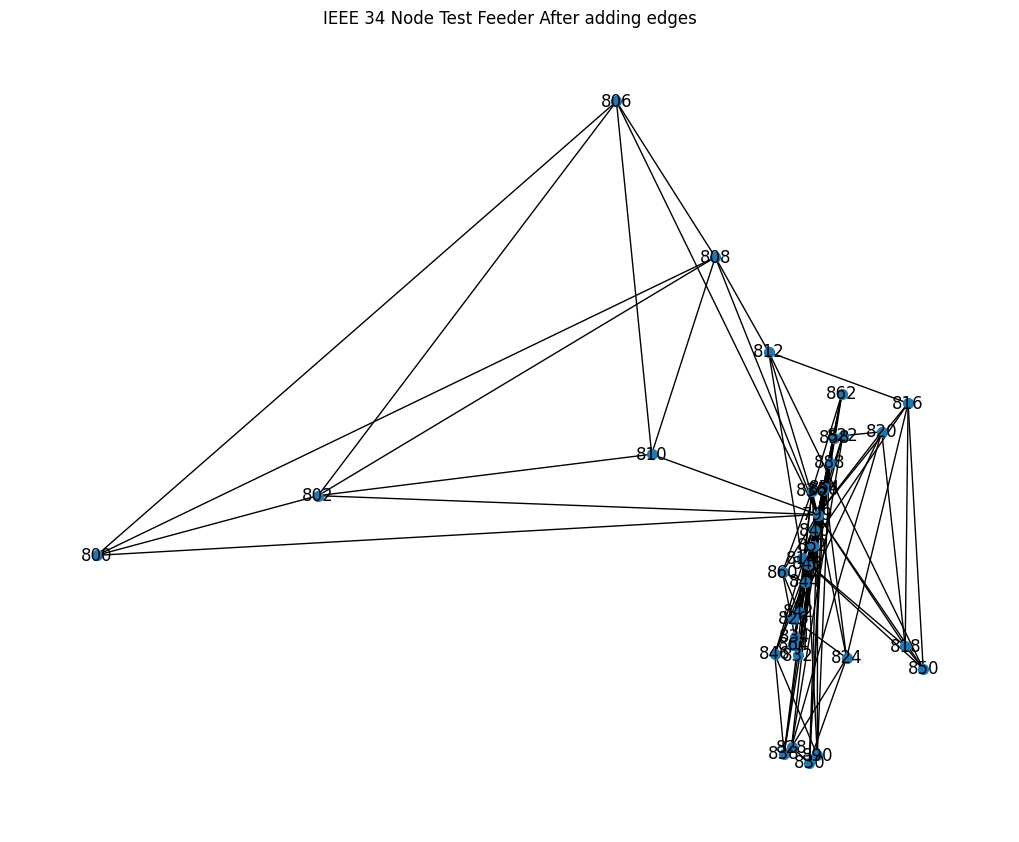

In [57]:
number_neighbors_to_add = 2

# Initialize a dictionary to keep track of the number of neighbors added to each node
added_edges_count = {node: 0 for node in G34.nodes}

for source_node in G34.nodes:
    # Calculate the shortest path lengths to all other nodes
    lengths = nx.single_source_shortest_path_length(G34, source_node)
    sorted_lengths = sorted(lengths.items(), key=lambda x: x[1])

    for target_node, steps in sorted_lengths:
        # Ignore already added edges
        if steps <= 1 or G34.has_edge(source_node, target_node):
            continue

        # Verify that the target node has enough neighbors to add
        if added_edges_count[source_node] < number_neighbors_to_add and added_edges_count[target_node] < number_neighbors_to_add:
            G34.add_edge(source_node, target_node)
            added_edges_count[source_node] += 1
            added_edges_count[target_node] += 1

        # if the target node has enough neighbors, stop adding edges
        if added_edges_count[source_node] >= number_neighbors_to_add:   
            break


plt.figure(figsize=(10, 8))
nx.draw(G34, with_labels=True, node_size=50, )
plt.title("IEEE 34 Node Test Feeder After adding edges")
plt.show()

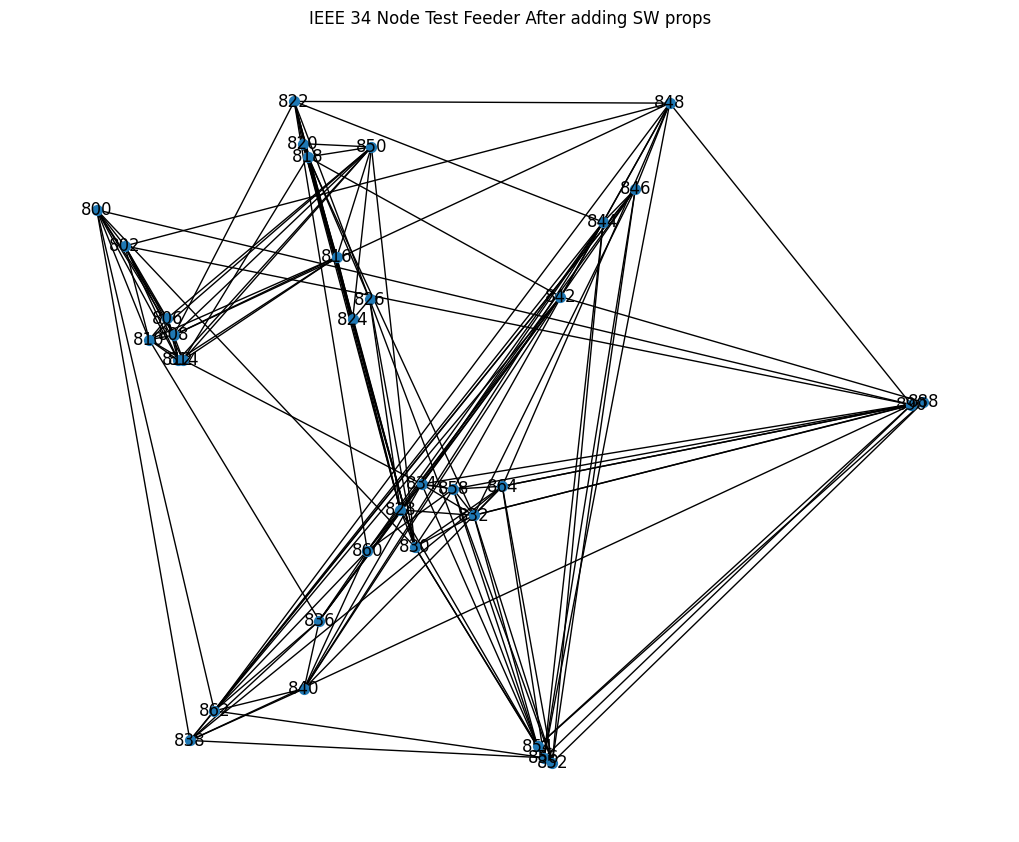

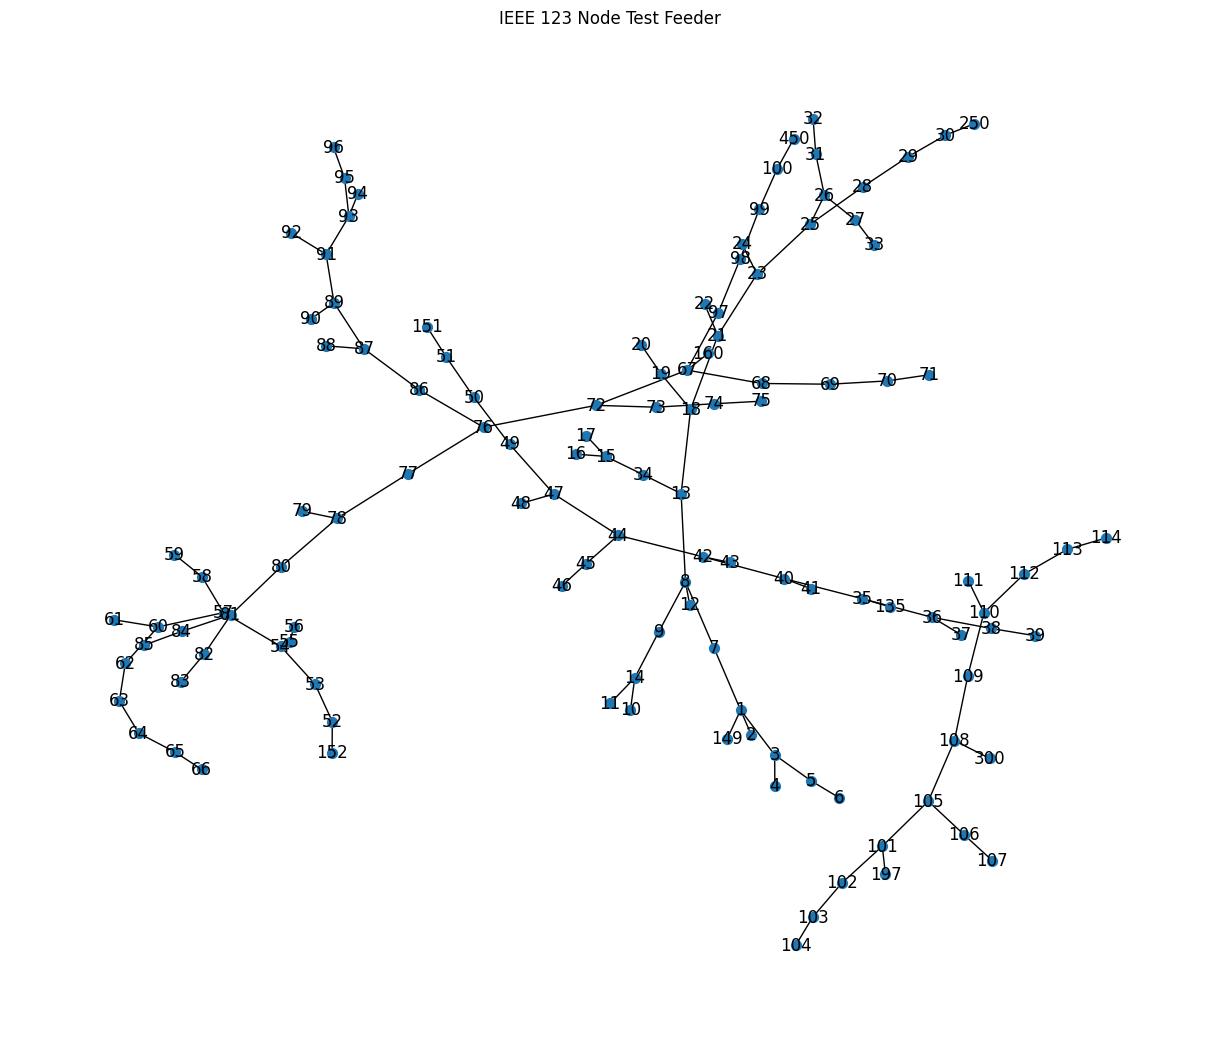

In [15]:

# --- props of SW approach ---

#Number of nodes
L = G34.number_of_nodes()
degrees = [deg for _, deg in G34.degree()]
K = sum(degrees) / len(degrees) 
# Average degree of the graph
p0 = K / (L - 1)
# Probability of a node to be connected to another node in orginal approach of WS
beta = 0.3
# Maximum distance between nodes
Dmax = L // 2
nodes = list(G34.nodes)

def ring_distance(i, j, L):
    return min(abs(i - j), L - abs(i - j))

def heaviside(x):
    return 1 if x >= 0 else 0

# --- add edges ---
for i in range(L):
    for j in range(i+1, L):
        Dij = ring_distance(i, j, L)
        dij = Dij / Dmax
        # Probability of a node to be connected to another node
        pij = beta * p0 + (1 - beta) * heaviside(p0 - dij)
        if not G34.has_edge(nodes[i], nodes[j]):
            if random.random() < pij:
                G34.add_edge(nodes[i], nodes[j])

for _, row in df123.iterrows():
    from_node = row["Node A"]
    to_node = row["Node B"]
    length = row["Length (ft.)"]
    config = row["Config."]

    G123.add_edge(from_node, to_node, length=length, config=config)

# Desenhar G34 After adding edges
plt.figure(figsize=(10, 8))
nx.draw(G34, with_labels=True, node_size=50)
plt.title("IEEE 34 Node Test Feeder After adding SW props")
plt.show()

# # # Desenhar G123
plt.figure(figsize=(12, 10))
nx.draw(G123, with_labels=True, node_size=50)
plt.title("IEEE 123 Node Test Feeder")
plt.show()

# display(df)